# Analysis for Low-dimensional Systems

@[Chaoming Wang](https://github.com/chaoming0625)

We have talked about model [simulation](../tutorial_simulation/index.rst) and [training](../tutorial_training/index.rst) for dynamical systems with BrainPy. In this section, we are going to dive into how to perform automatic analysis for your defined systems.  

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. BrainPy has well supports for low-dimensional systems, no matter how nonlinear your defined system is. Specifically, BrainPy provides the following methods for the analysis of low-dimensional systems:

1. phase plane analysis;
2. codimension 1 or codimension 2 bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 

BrainPy will help you probe the dynamical mechanism of your defined systems rapidly. 

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')
bp.math.enable_x64()  # It's better to enable x64 when performing analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A simple case

Here we test BrainPy with a simple case:

$$
\frac{dx}{dt} = \mathrm{sin}(x) + I,
$$

where $x \in [-10, 10]$.

As known to us all, this functuon has multiple fixed points ($\frac{dx}{dt} = 0$) when $I=0$.

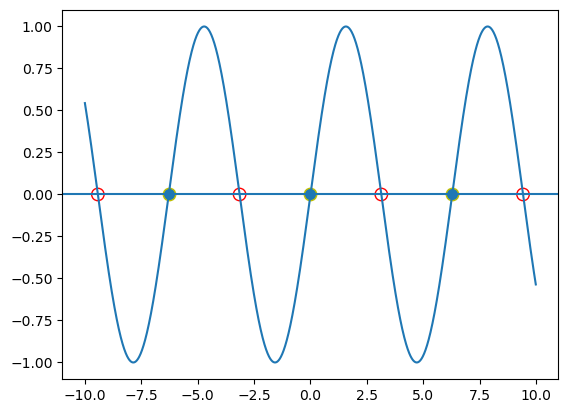

In [6]:
xs = np.arange(-10, 10, 0.01)

plt.plot(xs, np.sin(xs))
plt.scatter([-3*np.pi, -1*np.pi, 1*np.pi, 3 * np.pi], np.zeros(4), 
            s=80, facecolors='none', edgecolors='r')
plt.scatter([-2*np.pi, 0, 2*np.pi], np.zeros(3), s=80, edgecolors='y')
plt.axhline(0)
plt.show()

According to the dynamical theory, at the red hollow points, they are unstable; and for the solid ones, they are stable points. 

Now let's come back to BrainPy, and test whether BrainPy can give us the right answer. 

As the analysis interfaces in BrainPy only receives [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst) or instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst), we first define an integrator with BrainPy (if you want to know how to define an ODE integrator, please refer to the tutorial of [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb)):

In [3]:
@bp.odeint
def int_x(x, t, Iext):
    return bp.math.sin(x) + Iext

This is a one-dimensional dynamical system. So we are trying to use [brainpy.analysis.PhasePlane1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane1D.rst) for phase plane analysis. The usage of ``brainpy.analysis.PhasePlane1D`` will be detailed in the following section. Now, we just focus on the following four arguments:

- **model**: It specifies the target system to analyze. It can be a list/tuple of [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). However, it can also be an instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). For ``DynamicalSystem`` argument, we will use ``model.ints().subset(bp.ode.ODEIntegrator)`` to retrieve all instances of ODEIntegrator later. 
- **target_vars**: It specifies the variables to analyze. It must be a dict with the format of ``<var_name, var_interval>``, where ``var_name`` is the variable name, and ``var_interval`` is the boundary of this variable. 
- **pars_update**: Parameters to update. 
- **resolutions**: The resolution to evaluate the fixed points. 

Let's try it.

I am creating vector fields ...
I am searching fixed points ...
Fixed point #1 at x=-9.42477796076938 is a unstable point.
Fixed point #2 at x=-6.283185307179586 is a stable point.
Fixed point #3 at x=-3.141592653589793 is a unstable point.
Fixed point #4 at x=9.237056486678452e-19 is a stable point.
Fixed point #5 at x=3.141592653589793 is a unstable point.
Fixed point #6 at x=6.283185307179586 is a stable point.
Fixed point #7 at x=9.42477796076938 is a unstable point.


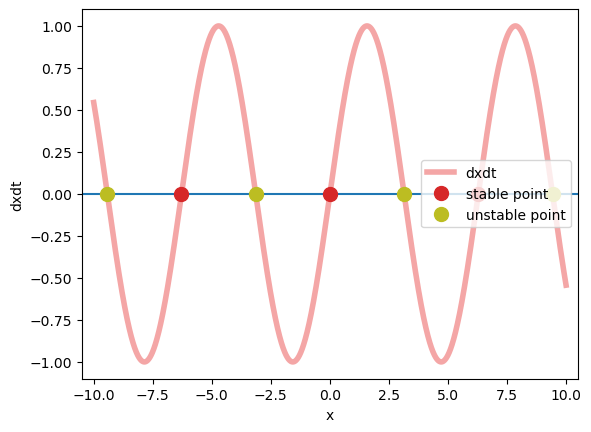

In [8]:
pp = bp.analysis.PhasePlane1D(
  model=int_x,
  target_vars={'x': [-10, 10]},
  pars_update={'Iext': 0.},
  resolutions=0.001
)
pp.plot_vector_field()
pp.plot_fixed_point(show=True)

Yeah, absolutelty, ``brainpy.analysis.PhasePlane1D`` gives us the right fixed points, and correctly evalutes the stability of these fixed points.  

Phase plane is important, because it give us the intuitive understanding how does the system evolve with the given parameters. However, in most cases, we care about how does the parameters affect the system behaviors. We should make bifurcation analysis. [brainpy.analysis.Bifurcation1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.Bifurcation1D.rst) is a convenient interface to help you rapidly get the insights of 1D system when the parameter changes. 

Similar to ``brainpy.analysis.PhasePlane1D``, ``brainpy.analysis.Bifurcation1D`` receives arguments like "model", "target_vars", "pars_update", and "resolutions". However, one more important argument **"target_pars"** should be provided. It specified the target parameter to make bifurcation analysis, with the setting of the parameter boundary.

Here, we systematically change the parameter "Iext" from 0 to 1.5. According to the bifurcation theory, we know this simple system has a fold bifurcation when $I=1.0$. Because at $I=1.0$, two fixed points collide with each other into a saddle point and then disappear. Does BrainPy's analysis toolkit ``brainpy.analysis.Bifurcation1D`` is capable of performing these analysis? Let's make a try.

I am making bifurcation analysis ...


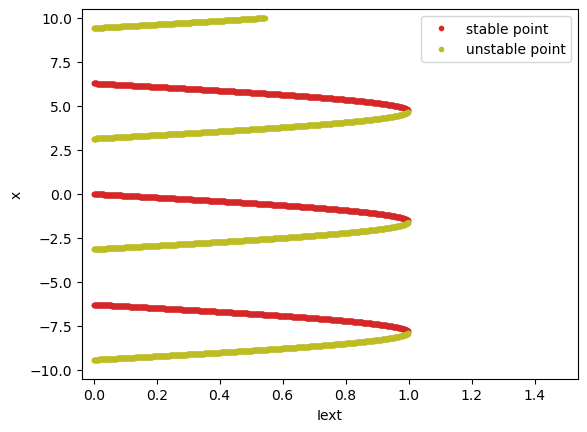

In [5]:
bif = bp.analysis.Bifurcation1D(
    model=int_x,
    target_vars={'x': [-10, 10]},
    target_pars={'Iext': [0., 1.5]},
    resolutions=0.001
)
bif.plot_bifurcation(show=True)

Once again, BrainPy analysis toolkit gives the right answer. It tells us how does the fixed points evolve when the parameter $I$ is increasing. 

However, it is worthy to note that bifurcation analysis in BrainPy is hard to find out the saddle point (when $I=0$ for this system). This is because the saddle point at the bifurcation just exists at a moment. While the numerical method used in BrainPy analysis toolkit is almost impossible to evaluate the point exactly at the saddle. However, if the user has the minimal knowledge about the bifurcation theory, saddle point (the collision point of two fixed points) can be easily infered from the fixed point evolution.

## Phase Plane Analysis


We provide a fundamental class ``PhasePlane`` to help users make
phase plane analysis for 1D/2D dynamical systems. Five methods
are provided, which can help you to plot:

- Fixed points
- Nullcline (zero-growth isoclines)
- Vector filed
- Limit cycles
- Trajectory

Here, I will illustrate how to do phase plane analysis by using a well-known neuron model FitzHugh-Nagumo model.

**FitzHugh-Nagumo model**

The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

In [2]:
a = 0.7
b = 0.8
tau = 12.5
Vth = 1.9


@bp.odeint
def int_fhn(V, w, t, Iext):
  dw = (V + a - b * w) / tau
  dV = V - V * V * V / 3 - w + Iext
  return dV, dw

Phase Plane Analysis is implemented in `brainpy.sym_analysis.PhasePlane`. It receives the following parameters: 

- ``integrals``: The integral functions or instance of ``brainpy.DynamicalSystem`` are going to be analyzed. 
- ``target_vars``: The variables to be analuzed. It must a dictionary with the format of `{var: variable range}`.
- ``fixed_vars``: The variables to be fixed (optional).
- ``pars_update``: Parameters to update (optional).

`brainpy.analysis.PhasePlane` provides interface to analyze the system's 

- **nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **fixed points**: The equilibrium points of the system, which are located at all of the nullclines intersect.
- **vector filed**: The vector field of the system.
- **Trajectory**: A given simulation trajectory with the fixed variables.
- **Limit cycles**: The limit cycles.

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

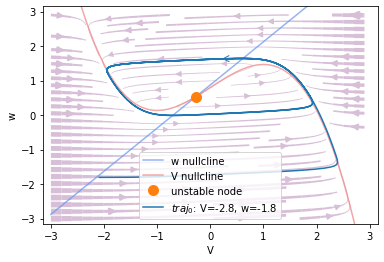

In [3]:
analyzer = bp.symbolic.PhasePlane(
  int_fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -2.8, 'w': -1.8}],
                         duration=100.,
                         show=True)

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. Then we can run a simulation with the same parameters and initial values to see the periodic activity that correspond to the limit cycle.

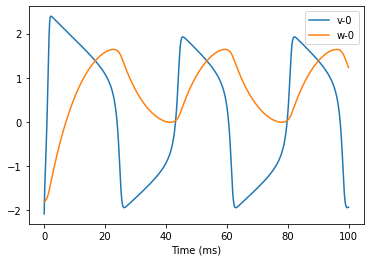

In [5]:
class FHN(bp.NeuGroup):
  def __init__(self, num, **kwargs):
    super(FHN, self).__init__(size=num, **kwargs)
    self.V = bp.math.Variable(bp.math.ones(num) * -2.8)
    self.w = bp.math.Variable(bp.math.ones(num) * -1.8)
    self.Iext = bp.math.Variable(bp.math.zeros(num))

  def update(self, _t, _dt):
    self.V[:], self.w[:] = int_fhn(self.V, self.w, _t, self.Iext)
    self.Iext[:] = 0.


group = FHN(1, monitors=['V', 'w'])
group.run(100., inputs=('Iext', 0.8))
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='v', )
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

Note that the `fixed_vars` can be used to specify the neuron model's state `ST`, it can also be used to specify the functional arguments in integrators (like the `Iext` in `int_v()`). 

## Bifurcation Analysis

Bifurcation analysis is implemented within `brainpy.sym_analysis.Bifurcation`. Which support codimension-1 and codimension-2 bifurcation analysis. Specifically, it receives the following parameter settings: 

- ``integrals``: The integral functions or instance of ``brainpy.DynamicalSystem`` are going to be analyzed.
- ``target_pars``: The target parameters. Must be a dictionary with the format of `{par: parameter range}`. 
- ``target_vars``: The target variables. Must be a dictionary with the format of `{var: variable range}`. 
- ``fixed_vars``: The fixed variables.
- ``pars_update``: The parameters to update.

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

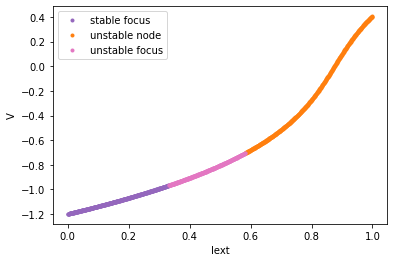

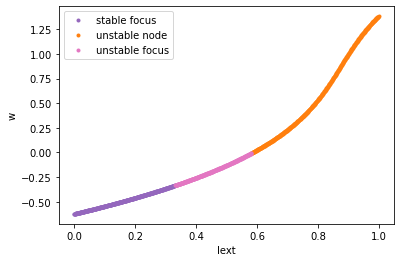

In [7]:
analyzer = bp.symbolic.Bifurcation(
  int_fhn,
  target_pars={'Iext': [0., 1.]},
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  numerical_resolution=0.001,
)
res = analyzer.plot_bifurcation(show=True)

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

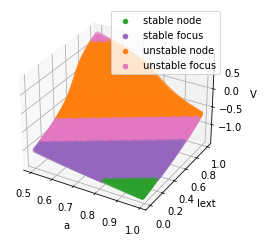

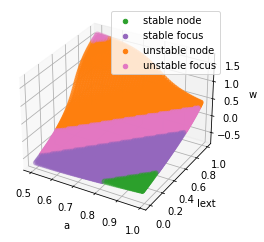

In [10]:
analyzer = bp.symbolic.Bifurcation(
  int_fhn,
  target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
  target_vars=dict(V=[-3, 3], w=[-3., 3.]),
  numerical_resolution=0.01,
)
res = analyzer.plot_bifurcation(show=True)

## Fast-Slow System Bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using `brainpy.sym_analysis.FastSlowBifurcation`. This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


`brainpy.sym_analysis.FastSlowBifurcation` is very usefull in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\begin{aligned}
\frac{d V}{d t} &= y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} &= c - d V^2 - y\\
\frac{d z}{d t} &= r (s (V - V_{rest}) - z)
\end{aligned}
$$

First of all, let's define the Hindmarsh–Rose model with BrainPy. 

In [11]:
a = 1.
b = 3.
c = 1.
d = 5.
s = 4.
x_r = -1.6
r = 0.001
Vth = 1.9


@bp.odeint(method='rk4', dt=0.02)
def int_hr(x, y, z, t, Isyn):
  dx = y - a * x ** 3 + b * x * x - z + Isyn
  dy = c - d * x * x - y
  dz = r * (s * (x - x_r) - z)
  return dx, dy, dz

We now can start to analysis the underlying bifurcation mechanism.

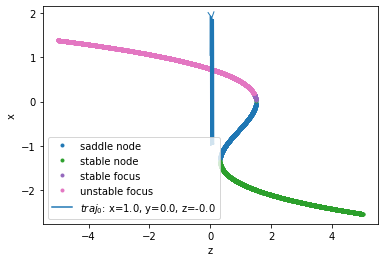

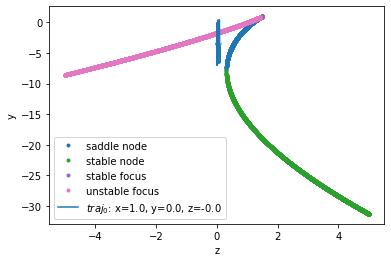

In [12]:
analyzer = bp.symbolic.FastSlowBifurcation(
  int_hr,
  fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
  slow_vars={'z': [-5., 5.]},
  pars_update={'Isyn': 0.5},
  numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'x': 1., 'y': 0., 'z': -0.0}],
                         duration=100.,
                         show=True)

**References**:

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.
